<h1><center>Problem Introduction</center></h1>

In this notebook, I will describe how I have approached the problem of classifing news in [*BBC-news dataset*](http://mlg.ucd.ie/datasets/bbc.html).
The dataset has been made available for non-commercial and research purposes thanks to the following work:
D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

<h1><center>Data Description</center></h1>
I am using the data that is  pre-processed as follows: 

* stemming (Porter algorithm), 
* stop-word removal (stop word list) and 
* low term frequency filtering (count < 3).

The cleaned data are suitable for bag-of-word approaches and the cleaned data helps me to save time  that I can dedicate to the  data analysis.

<h1><center>Objectives</center></h1>
It is important to understand what will be the accuracy/error that I should target in this classification problem.  This objective can be defined taking into account the previous results, the resource/time allocated for the project and the complexity of the problem. 

Commonly, the stakeholders need to be also involved in the definition of the objectives in order to take into account their needs, their technological stack and to understand how the accuracy/error is correlated to their KPIs and how this is impacting their revenues.
 
For this project, my objective is to create an initial solution by optimizing a state-of-the-art classifier.


<h1><center>Review of Previous Approaches</center></h1>

These are some of the proposed solutions for this dataset:

* [Topic modelling](http://bbcnewslabs.co.uk/2016/06/27/topicmodel-update/,) based on [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). In particular, the authors have shown that topic modeling in some circumstances can help in segmenting the data, but the approach has some limitation such as the interpretability of the topics, its applicability in dynamic corpus such as news data and the difficulty in selecting the number of topics. One of their main suggestions is to extend this approach toward a human-in-the-loop process.

* [Derek Greene and Pádraig Cunningham,2006](http://derekgreene.com/papers/greene06icml.pdf). The authors have used this dataset to evaluate an SVM-based approach for document clustering. They have measured the performances of the proposed clustering  in terms of Normalized Mutual Information [NMI] and Cluster Stability [CS]. In the reported results, one of their algorithms has achieved an NMI of  0.83 with a CS of 0.86.


In terms of methods for text classification  problem, interesting works can be found at the following links:

* [Fabrizio Sebastiani,2002.](https://arxiv.org/pdf/cs/0110053.pdf) is one of the most cited paper related to text classification.

* A comprehensive list of approaches can be found through the engine [Semantic Scholar](https://www.semanticscholar.org/) in this [web page](https://www.semanticscholar.org/search?year%5B%5D=2015&year%5B%5D=2018&facets%5Bkeyphrases%5D%5B%5D=Text%20Classification&q=text%20classification&sort=relevance&ae=false)

It is evident from the number of papers published on this topic every year, that still there is no winning solution for the text classification problem. In this case, the best approach is to experiment the most reliable method (both in terms of results in literature and availability of mature open-source tools), and then I will look how to improve the solutions in an iterative way driven by the observations risen from the data and experiments





<h1><center>Data Analysis</center></h1>

In [2]:
#Loading the data
import numpy as np
with open('bbc.terms','r') as fterms:
    terms=[ item.strip()for item in fterms]
    print('Loaded %d terms'%(len(terms)))

with open('bbc.docs','r') as fdocs:
    docs=[ item.strip()for item in fdocs]
    print('Loaded %d docs'%(len(docs)))

with open('bbc.classes','r') as fclasses:
    document_classes=[item.strip().split() for item in fclasses 
                      if item[0] is not '%']
    classes = [ item[1] for item in document_classes]
    classes_as_nparray = np.array(classes)
    num_classes = len(set(classes))
    print('Number of labels %d'%len(classes))
    print('Number of classes: %d'%(num_classes))

name_classes = 'business,entertainment,politics,sport,tech'.split(',')

Loaded 9635 terms
Loaded 2225 docs
Number of labels 2225
Number of classes: 5


Let me load sparse matrix (Matrix Market format) using the scipy library

In [3]:
#loading the matrix
from scipy.io import mmread
import numpy as np
matrix = mmread('bbc.mtx')
matrix_d = matrix.toarray()
print('Number of rows %d columns %d'%(matrix_d.shape))
#traspose the matrix such that we have document*term matrix that 
# can be used for classification purpose
matrix_d_t=np.transpose(matrix_d)
print('Number of rows %d columns %d after transposing the matrix'%(matrix_d_t.shape))

Number of rows 9635 columns 2225
Number of rows 2225 columns 9635 after transposing the matrix


##### Label Analysis #####
I am checking if I am dealing with an unbalanced classification problem, if so  I need to measure the performances mostly in terms of precision/recall or F-measure rather than of accuracy.

In [4]:
from collections import Counter
dict_classes_instances=dict(Counter(classes))
print('\n'.join([" Class %s has %d instances "%(key,dict_classes_instances[key]) 
                 for key in dict_classes_instances]))

 Class 0 has 510 instances 
 Class 1 has 386 instances 
 Class 2 has 417 instances 
 Class 3 has 511 instances 
 Class 4 has 401 instances 


There are some classes whose number of instances are quite different respect to others. It will be important for understanding the real performance of the method to look at the F-measure. At the same time, plotting the misclassification matrix can give some insights to understand the prediction errors among the classes.

##### How to compute the accuracy #####

In order to measure the performance, I will use a variant of the cross-validation approach. In particular, I will create a set of stratified randomized folds, and for each fold, I will measure the performance in terms of F1-score. 

To measure the accuracy result I will report the average of all the F-1 scores computed among the different runs.  I am making the hypothesis that these scores are normally distributed.

I would like to note that the stratified random splits do not guarantee that all folds will be different (although this is still very likely for sizeable datasets) but at least each partition will preserve the label distribution.

##### Baseline Definition #####

I will create a base line using a state-of-the-art classifier. In particular, I will choose a Random Forest (RF) classifier, which has shown good results in many classification problems [Rich Caruana and Alexandru Niculescu-Mizil,2006.](https://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml06.pdf) In particular, I will use the implementation from the [scikit-learn package](http://scikit-learn.org/stable/). 
The Random Forest classifier is an ensemble (bagging) method designed to reduce the variance of individual trees by randomly selecting (and thus de-correlating) many trees from the dataset, and averaging them.
The default split method used in the scikit-learn package is the [Gini Index](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). This classifier does not need any normalization of the features becouse the selection of the thresholds used to split the nodes of the tree is defined based on the ordering of the feature values rather than on the scale of the values.  Random forest is also an interesting solution because it reduces variance of a large number of "complex" models with low bias.

##### Hypothesis #####
The  RF  is assuming that the data space can be divided into a set of linear regions by applying in sequence some thresholding operations and the obtained regions are a model representation of our target labels. For example, if we have a 3-dimensional data space, the RF is "cutting" the data space in a set of cubes, where each cube is associated with a label.  

In the case of text classification,  where a feature space is modeled on the occurrences of the words (as in our cases), this means that we are making the hypothesis that given a document "D",  a rule based on occurrences of the words in "D", is enough to infer the class of "D".

The RF is a nonparametric approach for building classification
models. In other words, it does not require any prior assumptions
regarding the type of probability distributions satisfied by the class and other attributes [1].

[1] Pang-Ning Tan, Michael Steinbach, and Vipin Kumar. 2005. Introduction to Data Mining, (First Edition). Addison-Wesley Longman Publishing Co., Inc., Boston, MA, USA



##### Initial setting #####

For this initial analysis, I will use a standard configuration for the cross-validation as follows: 

* 10 rounds
* 50% split in training and testing


In the case of RF, the most common parameters are the following:

* the number of trees in the forest,
* the  splitting criteria,
* the number of feature to consider when looking for the best split,
* the depth of the tree.

In order to  have an initial measure of how the RF is performing with this dataset, I will use the following initial setting
taking into account the training/testing speed, the  memory usage and some rules of thumb:
    
* the number of trees in the forest (number of estimators) is equal to 100. In [2], it has been experimentally shown that a number around 100 is a good initial choice.
* the  splitting criteria  is equal to  Gini Index (default choice in scikit-learn)
* the number of features is  equal to sqrt(n_features)

Then, I will look  how to fine-tune these parameters.

[2]Thais Mayumi Oshiro, Pedro Santoro Perez, and José Augusto Baranauskas. 2012. How many trees in a random forest?. In Proceedings of the 8th international conference on Machine Learning and Data Mining in Pattern Recognition (MLDM'12),


In [5]:
#create a baseline performance using a Random Forest clssification algorithm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score

number_rounds = 10
test_size_value = 0.5
number_trees = 100

# I am using an initial setting a this stage, then I will do a fine 
# tunning of the parameters.
classifier = RandomForestClassifier(n_estimators=number_trees, 
                                    max_features="sqrt")

f1_score_list = []
cm_list = []
cm_max_list = []

rounds = StratifiedShuffleSplit(n_splits=number_rounds, 
                                test_size=test_size_value,
                                random_state=0)

for train_index, test_index in rounds.split(matrix_d_t,classes_as_nparray):
        matrix_train = matrix_d_t[train_index]
        classes_train = classes_as_nparray[train_index]
        matrix_test = matrix_d_t[test_index]
        classes_test = classes_as_nparray[test_index]
        classifier.fit(matrix_train,classes_train)
        classes_predicted = classifier.predict(matrix_test)
        cm = confusion_matrix(classes_test, classes_predicted)
        # normalize the confusion matrix
        cm= cm / cm.astype(np.float).sum(axis=1)
        #this threshold is used for plotting 
        thresh = cm.max() / 2.
        cm_list.append(cm)
        cm_max_list.append(thresh)
        #I compute the score taking into account the weighted schema, 
        #which means weighted by the support (the number of true instances for each label)
        precision, recall, fscore, support = score(classes_test, 
                                                   classes_predicted,
                                                   average='weighted')
        f1_score_list.append(fscore)


Compute the average F1 score among all the runs:

In [6]:
#The score method used in this case is the F1 score, which is the harmonic mean of precision and recall
F1_accuracy_str="F1 accuracy: %0.3f (+/- %0.3f)" % (np.mean(f1_score_list),
                                                    np.std(f1_score_list) * 2)
F1_accuracy = np.mean(f1_score_list)
print(F1_accuracy_str)


F1 accuracy: 0.957 (+/- 0.013)


Analyze the confusion matrix in order to get more insighs about the result of the classification process:

In [7]:
import pandas as pd
from sklearn.utils import shuffle
print('Extract (randomly) one confusion matrix from the previous run: ')
shuffle(cm_list,random_state=15)
cnf_matrix = cm_list[0]
dataframe=pd.DataFrame(cnf_matrix,index=name_classes,columns=name_classes)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(dataframe)

Extract (randomly) one confusion matrix from the previous run: 
               business  entertainment  politics  sport   tech
business         0.9725         0.0000    0.0191 0.0000 0.0150
entertainment    0.0078         0.9585    0.0000 0.0117 0.0150
politics         0.0353         0.0052    0.9474 0.0039 0.0000
sport            0.0078         0.0000    0.0000 0.9922 0.0000
tech             0.0275         0.0104    0.0048 0.0117 0.9350


Plot the confusion matrix at least of  3 runs (randomly selected, I fixed the random state for having replicable results).
The following code is a modification of a script posted [here]( 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

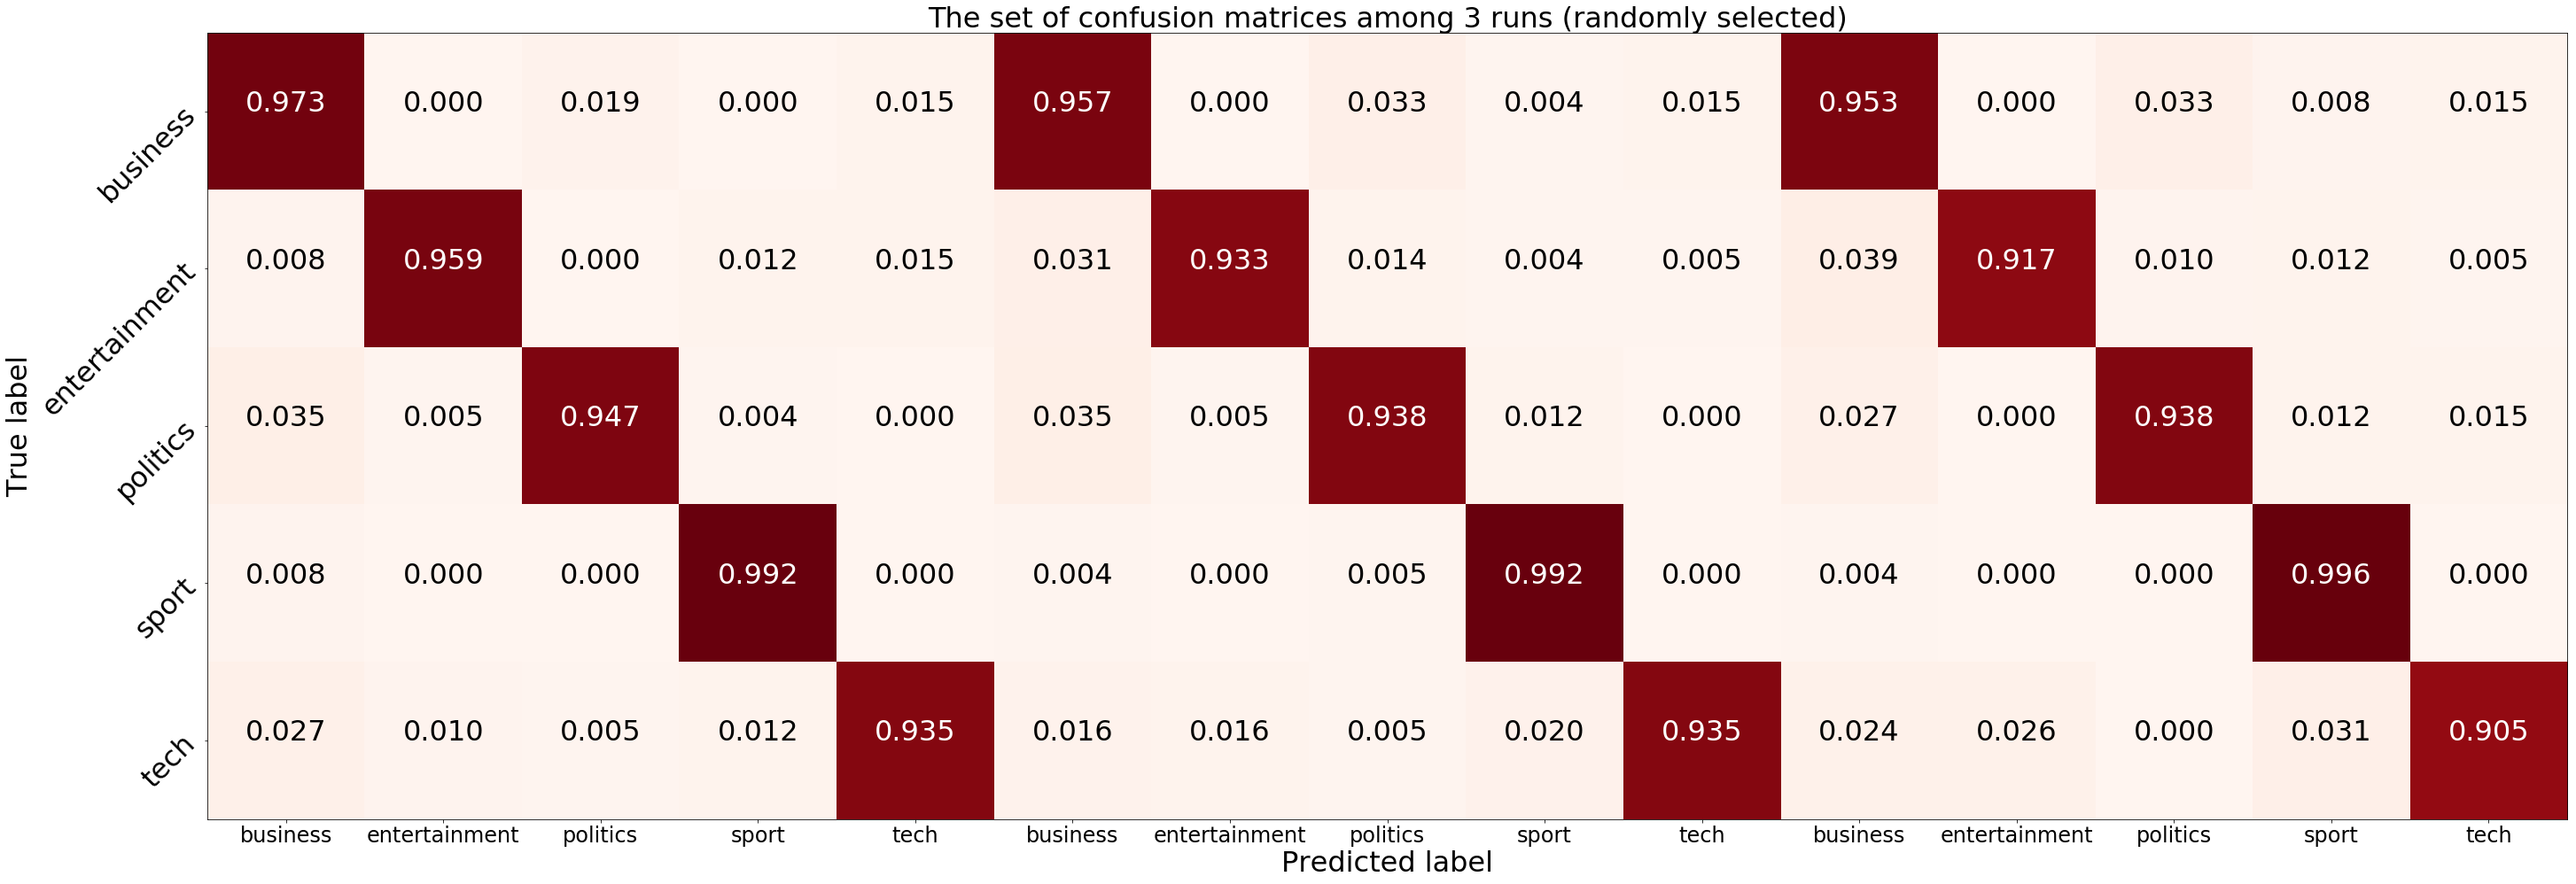

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle

cm_list_selection, cm_max_list_selection = shuffle(cm_list, cm_max_list,random_state=34)
cm_list_selection = cm_list_selection[:3]
cm_max_list_selection = cm_max_list_selection[:3]

stack_matrix = np.hstack(cm_list_selection)

classes_stacked = len(cm_list_selection)*name_classes

plt.figure(figsize=(40, 100))
plt.imshow(stack_matrix, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("The set of confusion matrices among 3 runs (randomly selected)",size=32)

plt.yticks(np.arange(len(name_classes)), name_classes, rotation=45,size=32)
plt.xticks(np.arange(len(classes_stacked)),classes_stacked,size=24)


for k in range(0,len(cm_list_selection)):
    for i, j in itertools.product(range(cm_list[0].shape[0]), 
                                  range(cm_list[0].shape[1])):
        plt.text(j+k*num_classes, i,('%0.3f')%(stack_matrix[i, j+k*num_classes]), 
                 horizontalalignment="center",color="white" 
                 if stack_matrix[i, j] > cm_max_list_selection[k] 
                 else "black",size=32)
plt.tight_layout()
plt.ylabel('True label',size=32)
plt.xlabel('Predicted label',size=32)

I have obtained an initial F1 score of ~ 96%.  From the confusion matrix, it looks like that the classifier is not able to well separate the following data spaces:

* some "business" documents are labeled with "politics" and "tech" ones (error (false negative) ~1.5%)

* some "entertainment" documents are labeled with "business" and "tech" (error (false negative) ~1.5%)

* some "politics" documents are labeled with "business"  (error (false negative) ~1.5%)

* some "tech" documents are labeled with "business", "entertainment", "sport" (error (false negative) ~1.5%)


The documents related to "sports" are well classified.

The errors in the classification is distributed quite uniformly, mainly due to the common terms shared among the classes.

In this case, I can improve the results choosing one of the following strategies:

1. fine-tuning the parameters of the RF classifiers,
2. develop better features. For example, I have used the raw counts of the terms while it could better a [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) approach,
3. design a different classification algorithm.


First, I will try  randomized search on hyper parameters to see if I can improve the results of this initial configuration.

The idea of the randomized search is to fine-tuning the parameters by sampling them and then configure and evaluate the classifier.

This choice is quite fast respect to an exhaustive search.

For this analysis, I have modified the script posted [here](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html) 


In particular, I will split the data in traning (80%) and testing (20%), then I will use 30% of the traning data as validation set to fine-tune the parameters.

Generally, the larger the training data the better the classifier is, or the larger the test data the more accurate is the error estimate.


An interesting dicussion about how to split the dataset in training, testing, and validation in more complex scenarios can be found [here](https://www.youtube.com/watch?v=F1ka6a13S9I). 

In [106]:

from sklearn.model_selection import RandomizedSearchCV
from time import time

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# this is the parameter space
max_features = int(np.sqrt(matrix_d_t.shape[0]))
number_samples_features = int(max_features/2)

# same seed to ensure replicability of the experiments 
np.random.seed(35)

max_features_selection = np.random.choice(range(1,max_features),
                                          number_samples_features,
                                          replace=False)
min_samples_split_selection = np.random.choice(range(2,20),10,
                                               replace=False)
min_samples_leaf_selection = np.random.choice(range(2,20),10,
                                              replace=False)
estimator_selection = np.random.choice(range(20,300),100,
                                       replace=False)
depth_selection = [3,5,None]

np.random.seed()

param_dist = { "n_estimators":estimator_selection,
               "max_depth": depth_selection,
              "max_features": max_features_selection,
              "min_samples_split": min_samples_split_selection,
              "min_samples_leaf": min_samples_leaf_selection,
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}



# build a classifier
classifier_to_tune = RandomForestClassifier()

# run randomized search
n_iter_search = 200
random_search = RandomizedSearchCV(classifier_to_tune, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,random_state=32)

rounds_train_validation_test = StratifiedShuffleSplit(n_splits=1, 
                                                      test_size=0.2,
                                                      random_state=11)

for train_validation_index, test_index in rounds_train_validation_test.split(matrix_d_t,
                                                                             classes_as_nparray):
        
        matrix_train_validation = matrix_d_t[train_validation_index]
        classes_train_validation = classes_as_nparray[train_validation_index]
        matrix_test = matrix_d_t[test_index]
        classes_test = classes_as_nparray[test_index]


rounds_train_validation  = StratifiedShuffleSplit(n_splits=1, 
                                                  test_size=0.3,
                                                  random_state=79)
        
for train_index, validation_index in rounds_train_validation.split(matrix_train_validation,
                                                                   classes_train_validation):
        
        matrix_train= matrix_train_validation[train_index]
        classes_train= classes_train_validation[train_index]
        matrix_validation = matrix_train_validation[validation_index]
        classes_validation = classes_train_validation[validation_index]

start = time()
random_search.fit(matrix_validation, classes_validation)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 218.70 seconds for 200 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.959 (std: 0.023)
Parameters: {'n_estimators': 177, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 23, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.951 (std: 0.023)
Parameters: {'n_estimators': 141, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 40, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.948 (std: 0.016)
Parameters: {'n_estimators': 183, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 38, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': False}



Test the RF classifier with the first model (rank 1): 

Parameters: {'n_estimators': 177, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 23, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

I got very similar performances among all the settings, so there is not winning configuration.

I note that the mean validation score is a different measure from the F1 score which I am using to measure the performance. The above rank just helps me to select the best model.

In [107]:
classifier_tunned = RandomForestClassifier(n_estimators=177, min_samples_split= 13, 
                                           min_samples_leaf= 2, 
                                           max_features= 23, 
                                           max_depth= None, 
                                           criterion= 'gini', 
                                           bootstrap=False)



classifier_tunned.fit(matrix_train,classes_train)
classes_predicted = classifier_tunned.predict(matrix_test)
precision, recall, fscore, support = score(classes_test, classes_predicted,
                                           average='weighted')

"F1 accuracy: %0.3f after fine-tuning the Random Forest classifier" % (np.mean(fscore))



'F1 accuracy: 0.962 after fine-tuning the Random Forest classifier'

The fine tuning of the RF classifier does not give a great improvement in terms of F1 accuracy respect to the original choice. 

Instead of doing full grid search that is quite expensive, it will be interesting to measure the performance of an SVM classifier with TF-IDF based features, which is also a very common solution in the text classification problem.

This choice is also justified by the observations in the previous experiment that to reduce the misclassification errors we need to better discriminate the words within their context (business, entertainment, politics and so on.. )

TF-IDF is the simplest approach that helps me to weight the words within the documents and the vocabulary/corpus, so in some sense, this weighted schema takes into account the importance of the term in the document with respect to its whole appearance in the whole corpus.

A more advanced context-oriented approach should be based on distributional semantic like the [word2vec approach](https://en.wikipedia.org/wiki/Word2vec).


##### Comparison between Random Forest and SVM with TF-IFD features ##### 
I will compare the performance of a Random Forest vs an SVM classifier both on the TF-IDF weighting scheme.

In the scikit-learn, there are different implementations of the SVMs.

In particular, I will use the implementation based on [Stochastic Gradient Descent (SGD) learning algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) with hinge loss, which gives a linear SVM. 

This is a solution that is able to scale better in the case of a large dataset. It differs from  the classical approaches based on
solving a convex optimization problem but it is based on the stochastic gradient descent algorithm, which has the goal to minimize the expected loss.

In the case of SGD algorithm, the features should be scaled such that all the components in the data space have zero mean and unit variance in order to improve the convergence of the algorithm. 

In the case of sparse data like this data, this standardization will modify the features space changing the data distributions towards the zeros, so I will not apply any preprocessing on the feature space.  

Therefore, in the TF-IDF feature space, the components have similar scales because they all refer to similar variables (i.e. terms).

In [109]:
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support as score



# I am using the same configuration of the RF used in the initial analysis, 
# in order to have a fair comparison, 
#without considering the fine-tuned classifier.

classifier_RF = RandomForestClassifier(n_estimators=number_trees, 
                                       max_features="sqrt")

# At this stage, I will use default options for the SVM classifier
# Due to the fact that it is an unbalanced problem I am using the class_weight option, 
# which is  set  to “balanced” mode (automatically adjust weights inversely 
# proportional to class frequencies in the input data)
# I will also use a fixed random state, because in the SGD algorithm 
# there is shuffle operation that is done at start,
# so a  fixed random state is used to have similar results on different runs.

classifier_SVM = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,
                               class_weight='balanced',random_state=38)

f1_score_list_RF = []
f1_score_list_SVM = []



# I have the same splitting of the previous analysis (random_state is the same).

rounds = StratifiedShuffleSplit(n_splits=number_rounds, 
                                test_size=test_size_value,
                                random_state=0)

 # I am going to use the default options for TF-IDF class, 
# typically I did not experiment much differences 
# in choosing different parameters like L1 or L2 normalization. 

tfidf = TfidfTransformer()
    

for train_index, test_index in rounds.split(matrix_d_t,classes_as_nparray):
        
        matrix_train = matrix_d_t[train_index]
        classes_train = classes_as_nparray[train_index]
        matrix_test = matrix_d_t[test_index]
        classes_test = classes_as_nparray[test_index]
       
        # The training data will be used to create the corpus for the TF-IDF (fit)
        # where the test data will be mapped (transform)
           
        matrix_train_tf_idf = tfidf.fit_transform(matrix_train)
        matrix_test_tf_idf =  tfidf.transform(matrix_test)
        
        # fit the RF classfier with the tf-idf matrix
        
        classifier_RF.fit(matrix_train_tf_idf,classes_train)
        classes_predicted_RF = classifier_RF.predict(matrix_test_tf_idf)
        
        #I compute the score taking into account the weighted schema, 
        #which means weighted by the support (the number of true instances for each label)
        precision_RF, recall_RF, fscore_RF, support_RF = score(classes_test, 
                                                               classes_predicted_RF,
                                                               average='weighted')
        f1_score_list_RF.append(fscore_RF)
        
        classifier_SVM.fit(matrix_train_tf_idf,classes_train)
        classes_predicted_SVM = classifier_SVM.predict(matrix_test_tf_idf)
        
        #I compute the score taking into account the weighted schema, 
        #which means weighted by the support (the number of true instances for each label)
        precision_SVM, recall_SVM, fscore_SVM, support_SVM = score(classes_test, 
                                                                   classes_predicted_SVM,
                                                                   average='weighted')
        f1_score_list_SVM.append(fscore_SVM)
        
        
        


In [110]:
print(" RF : F1 accuracy: %0.3f (+/- %0.2f)" % (np.mean(f1_score_list_RF),
                                                np.std(f1_score_list_RF) * 2))
print(" SVM : F1 accuracy: %0.3f (+/- %0.2f)" % (np.mean(f1_score_list_SVM),
                                                 np.std(f1_score_list_SVM) * 2))


 RF : F1 accuracy: 0.957 (+/- 0.01)
 SVM : F1 accuracy: 0.976 (+/- 0.01)


The SVM is performing better than RF without any fine-tuning of its parameters. 

 In this dataset, the "hinge" loss and "one versus all" approach (used in the SGD classifier for multi-class problems) is more effective than splitting the data space linearly based on some information based criteria.


I fine tune the SGD classifier:

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from time import time

# this is the parameter space, in this case, I will also consider different loss functions, 
# not just the hinge one (SVM)
# in particular "log" and 'modified_huber' have shown good results 
# for multi-classification problem
tuned_parameters = [{'loss': ['hinge', 'log', 'modified_huber'], 
                     'penalty':['l2', 'l1'],
                     'alpha': [ 1e-2, 1e-3, 1e-4, 1e-5, 1e-6 ],
                     'learning_rate':['optimal'],
                     'class_weight':['balanced']}]


# build a classifier
classifier_to_tune= SGDClassifier()


# run grid search

grid = GridSearchCV(classifier_to_tune, tuned_parameters)

tfidf = TfidfTransformer()


rounds_train_validation_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2,
                                                      random_state=129)

for train_validation_index, test_index in rounds_train_validation_test.split(matrix_d_t,
                                                                             classes_as_nparray):
        
        matrix_train_validation = matrix_d_t[train_validation_index]
        classes_train_validation = classes_as_nparray[train_validation_index]
        matrix_test = matrix_d_t[test_index]
        classes_test = classes_as_nparray[test_index]
        
        
        


rounds_train_validation  = StratifiedShuffleSplit(n_splits=1, 
                                                  test_size=0.3,
                                                  random_state=162)
        
for train_index, validation_index in rounds_train_validation.split(matrix_train_validation,
                                                                   classes_train_validation):
        
        matrix_train= matrix_train_validation[train_index]
        classes_train= classes_train_validation[train_index]
        matrix_validation = matrix_train_validation[validation_index]
        classes_validation = classes_train_validation[validation_index]
     

matrix_train_tf_idf = tfidf.fit_transform(matrix_train)
matrix_test_tf_idf =  tfidf.transform(matrix_test)

matrix_validation_tf_idf = tfidf.fit_transform(matrix_validation)
       

start = time()

# summarize the results of the grid search
start = time()
grid.fit(matrix_validation_tf_idf, classes_validation)
print("GridSearchCV took %.2f seconds" % ((time() - start)))
report(grid.cv_results_)

GridSearchCV took 1.46 seconds
Model with rank: 1
Mean validation score: 0.979 (std: 0.003)
Parameters: {'alpha': 0.001, 'class_weight': 'balanced', 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.978 (std: 0.000)
Parameters: {'alpha': 0.0001, 'class_weight': 'balanced', 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.978 (std: 0.004)
Parameters: {'alpha': 1e-05, 'class_weight': 'balanced', 'learning_rate': 'optimal', 'loss': 'log', 'penalty': 'l2'}



From this analysis, I chose the model :
Model with rank: 1
Mean validation score: 0.979 (std: 0.003)
Parameters: {'alpha': 0.001, 'class_weight': 'balanced', 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}

In [115]:
classifier_tunned = SGDClassifier(alpha=0.001, class_weight='balanced', 
                                  learning_rate='optimal', 
                                  loss='hinge', penalty= 'l2')



classifier_tunned.fit(matrix_train_tf_idf,classes_train)
classes_predicted = classifier_tunned.predict(matrix_test_tf_idf)
precision, recall, fscore, support = score(classes_test, 
                                           classes_predicted,
                                           average='weighted')

"F1 accuracy: %0.3f after fine-tuning the SGD" % (np.mean(fscore))

'F1 accuracy: 0.978 after fine-tuning the SGD'

The fine tuning has provided the same level of F1 accuracy of the initial experiment.

The SVM that I am using is still a linear classifier, I would like to check if using an [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) with a radial kernel can help. 

In particular, the radial kernel helps to separate the data space (in the case of no linear decision boundary)  by mapping this original space in a higher dimension where the different classes can be separated linearly.


I can further improve the latest accuracy by fine-tuning an SVM classifier with the (Gaussian) radial basis function kernel. I am using a code snapshot similar to the one used in the previous steps.

In [119]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from time import time

# this is the parameter space
tuned_parameters = [{'kernel': ['rbf'], 
                     'gamma': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                     'C': [1, 10, 100, 1000, 10000],
                     'decision_function_shape':['ovo', 'ovr'],
                     'class_weight':['balanced']}]


# build a classifier
classifier_to_tune=SVC(C=1)

# run grid search

grid = GridSearchCV(classifier_to_tune, tuned_parameters)

tfidf = TfidfTransformer()


rounds_train_validation_test = StratifiedShuffleSplit(n_splits=1, 
                                                      test_size=0.2,
                                                      random_state=39)

for train_validation_index, test_index in rounds_train_validation_test.split(matrix_d_t,
                                                                             classes_as_nparray):
        
        matrix_train_validation = matrix_d_t[train_validation_index]
        classes_train_validation = classes_as_nparray[train_validation_index]
        matrix_test = matrix_d_t[test_index]
        classes_test = classes_as_nparray[test_index]
        
        
        


rounds_train_validation  = StratifiedShuffleSplit(n_splits=1, test_size=0.3,
                                                  random_state=29)
        
for train_index, validation_index in rounds_train_validation.split(matrix_train_validation,
                                                                   classes_train_validation):
        
        matrix_train= matrix_train_validation[train_index]
        classes_train= classes_train_validation[train_index]
        matrix_validation = matrix_train_validation[validation_index]
        classes_validation = classes_train_validation[validation_index]
     

matrix_train_tf_idf = tfidf.fit_transform(matrix_train)
matrix_test_tf_idf =  tfidf.transform(matrix_test)

matrix_validation_tf_idf = tfidf.fit_transform(matrix_validation)
       

start = time()

# summarize the results of the grid search
start = time()
grid.fit(matrix_validation_tf_idf, classes_validation)
print("GridSearchCV took %.2f seconds" % ((time() - start)))
report(grid.cv_results_)

GridSearchCV took 79.13 seconds
Model with rank: 1
Mean validation score: 0.966 (std: 0.008)
Parameters: {'C': 100, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.966 (std: 0.008)
Parameters: {'C': 100, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': 0.01, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.966 (std: 0.008)
Parameters: {'C': 1000, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.966 (std: 0.008)
Parameters: {'C': 1000, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.966 (std: 0.008)
Parameters: {'C': 1000, 'class_weight': 'balanced', 'decision_function_shape': 'ovr', 'gamma': 0.01, 'kernel': 'rbf'}

Model with rank: 1
Mean validation score: 0.966 (std: 0.008)
Paramete

There is not much difference in terms of validation score among the previous model, so I will select the first one:
Model with rank: 1
Mean validation score: 0.966 (std: 0.008)
Parameters: {'C': 100, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'rbf'}


In [120]:
classifier_tunned = SVC(C= 100, class_weight= 'balanced', 
                        gamma=0.01, kernel='rbf',
                        decision_function_shape= 'ovo')

classifier_tunned.fit(matrix_train_tf_idf,classes_train)
classes_predicted = classifier_tunned.predict(matrix_test_tf_idf)
precision, recall, fscore, support = score(classes_test, 
                                           classes_predicted,
                                           average='weighted')

"F1 accuracy: %0.3f after fine-tuning the SVC" % (np.mean(fscore))

'F1 accuracy: 0.973 after fine-tuning the SVC'

From the above analysis, the SGD classifier (linear SVM) with TF-IDF feature is performing similarly to the SVM (radial kernel) a bit better than RF classifier.

The SGD solution has the advantage that scales better on large data set, so it is the best solution to adapt for data set similar to this one.

At same time SGD is the simplest solution so it is in line the Occam’s Razor principle: "the best theory is the simplest one that describes all the facts."

An interesting discussion about pro/contra of the most famous algorithm can be found [here](https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms/answer/Xavier-Amatriain?share=04542762&srid=8Ouu)

At this stage, it will be better to assess the performances of the SGD classifier with cross validation:

In [126]:
from sklearn.model_selection import cross_val_score
classifier_sgd_tunned = SGDClassifier(alpha=0.0001, class_weight='balanced', 
                                      learning_rate='optimal', 
                                  loss='hinge', penalty= 'l2')
tfidf = TfidfTransformer()
# In this case I will assume that the vocabulary is fixed between training and testing, so I fit and transform once all the 
# matrix to get the TF-IDF values  
matrix_d_t_tf_idf=tfidf.fit_transform(matrix_d_t)
scores = cross_val_score(classifier_sgd_tunned, matrix_d_t_tf_idf,classes_as_nparray, 
                         cv=5, scoring='f1_weighted')
print(" The F1 score (weighted by class support) : %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

 The F1 score (weighted by class support) : 0.968 (+/- 0.031)



##### Results ##### 
The cross validation has confirmed the performance of the SGD classifier (linear SVM) around 97% (F1 score)


<h1><center>Future Work</center></h1>


As future work, it will be interesting to measure the classification performance of the following approaches:

* Build data representation based on [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) or other [Bayesian Nonparametric Generative Models](https://arxiv.org/abs/1106.2697). In these approaches, we can project the documents in the topics space and then run the classification methods in this new space.

* Build a text classification system based on [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) as described in one of the [examples](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/learn/text_classification.py) of [TensorFlow](https://www.tensorflow.org/) 

* Build a text representation with [AutoEncoder](https://www.cs.toronto.edu/~hinton/science.pdf) or [Variational Autoencoder](https://www.aaai.org/ocs/index.php/AAAI/AAAI17/paper/download/14299/14261) and then use this new compressed space for the classification.

An interesting tool to evaluate within this context is the 
[FastText](https://github.com/facebookresearch/fastText) from the Facebook Research lab.

In particular, in this [paper](https://arxiv.org/pdf/1607.01759.pdf), the authors have claimed that this tool is able to  obtain performances
on par with recently proposed methods inspired by deep learning in several NLP tasks while being much faster.